# Train & Test Dataset HerbalEase


In [2]:
import os
import zipfile
import gdown
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

## Dataset


In [3]:
# Fungsi untuk mengunduh file dari Google Drive menggunakan URL
def download_file_from_google_drive(url, dest_path):
    gdown.download(url, dest_path, quiet=False)

# Fungsi untuk mengekstrak file zip
def extract_zip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"File diekstraksi ke: {extract_to}")

# URL file Google Drive
url = 'https://drive.google.com/uc?id=1k36oZj_AdwperONZGKSE3z6qtxwMeQGx'
destination = 'dataset.zip'
extract_to = 'dataset'  # Direktori tujuan untuk mengekstraksi file

# Unduh file dari Google Drive
download_file_from_google_drive(url, destination)

# Ekstrak file zip
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

extract_zip_file(destination, extract_to)

# Hapus file zip setelah diekstraksi (opsional)
os.remove(destination)

Downloading...
From (original): https://drive.google.com/uc?id=1k36oZj_AdwperONZGKSE3z6qtxwMeQGx
From (redirected): https://drive.google.com/uc?id=1k36oZj_AdwperONZGKSE3z6qtxwMeQGx&confirm=t&uuid=c7e7db73-fbcc-4b91-bb6e-6f01414dbf85
To: /content/dataset.zip
100%|██████████| 4.13G/4.13G [00:55<00:00, 74.5MB/s]


File diekstraksi ke: dataset


In [4]:
dataset_dir = 'dataset/Dataset Tanaman Herbal/Dataset Tanaman Herbal'

train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'test')

In [5]:
# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_dir))} images of herbalease for training.\n")
print(f"There are {len(os.listdir(validation_dir))} images of herbalease for validation.\n")

There are 29 images of herbalease for training.

There are 29 images of herbalease for validation.



## Training and Validation Generators

In [6]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    """
    Creates the training and validation data generators.

    Args:
        TRAINING_DIR (str): Directory path containing the training images.
        VALIDATION_DIR (str): Directory path containing the validation images.

    Returns:
        tuple: Training and validation data generators.
    """
    # Instantiate the ImageDataGenerator for training with data augmentation and normalization
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,  # Rescale pixel values for normalization
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Create a training generator
    train_generator = train_datagen.flow_from_directory(
        directory=TRAINING_DIR,
        batch_size=64,  # Batch size of 32 is a common choice
        class_mode='categorical',  # For binary classification (cats vs. dogs)
        target_size=(150, 150)  # Resize images to 150x150
    )

    # Instantiate the ImageDataGenerator for validation without augmentation but with normalization
    validation_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Normalize pixel values

    # Create a validation generator
    validation_generator = validation_datagen.flow_from_directory(
        directory=VALIDATION_DIR,
        batch_size=32,  # Batch size of 32 is a common choice
        class_mode='categorical', # For binary classification (cats vs. dogs)
        target_size=(150, 150)  # Resize images to 150x150
    )

    # Return the training and validation generators
    return train_generator, validation_generator

In [7]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 15428 images belonging to 29 classes.
Found 1805 images belonging to 29 classes.


In [8]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-06-20 14:02:18--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.207, 74.125.202.207, 74.125.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   148MB/s    in 0.6s    

2024-06-20 14:02:19 (148 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [10]:
def create_pre_trained_model(local_weights_file):
    """
    Initializes an InceptionV3 model and loads pretrained weights.

    Args:
        local_weights_file (str): Path pointing to a pretrained weights H5 file.

    Returns:
        pre_trained_model: The initialized InceptionV3 model.
    """
    # Initialize the InceptionV3 model with the specified input shape and exclude top layers
    pre_trained_model = InceptionV3(input_shape=(150, 150, 3),  # Target size (150, 150, 3) for RGB images
                                    include_top=False,  # Exclude top layers
                                    weights=None)  # Weights will be loaded later from the file

    pre_trained_model.load_weights(local_weights_file)

    for layer in pre_trained_model.layers:
        layer.trainable = False

    return pre_trained_model

In [11]:

pre_trained_model = create_pre_trained_model(local_weights_file)

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [12]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


## Creating callbacks for later


In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
      print("\nReached 99% accuracy and val_accuracy, so cancelling training!")
      self.model.stop_training = True

In [14]:
def output_of_last_layer(pre_trained_model):
    """
    Gets the last layer output of a model.

    Args:
        pre_trained_model (tf.keras.Model): Model to get the last layer output from.

    Returns:
        last_output: Output of the model's last desired layer.
    """
    last_desired_layer = pre_trained_model.get_layer('mixed7')

    print('last layer output shape: ', last_desired_layer.output_shape)

    last_output = last_desired_layer.output

    print('last layer output: ', last_output)

    return last_output

In [15]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [16]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.engine.functional.Functional'>


In [17]:
def create_final_model(pre_trained_model, last_output):

    x = layers.Flatten()(last_output)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(29, activation='softmax')(x)
    model = Model(inputs=pre_trained_model.input, outputs=x)
    model.compile(optimizer=RMSprop(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [18]:
model = create_final_model(pre_trained_model, last_output)

total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,541,181 total parameters in this model.
There are 38,565,917 trainable parameters in this model.


In [19]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 10,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/10
242/242 - 1120s - loss: 0.4115 - accuracy: 0.8820 - val_loss: 0.4063 - val_accuracy: 0.8720 - 1120s/epoch - 5s/step
Epoch 2/10
242/242 - 1107s - loss: 0.1443 - accuracy: 0.9546 - val_loss: 0.3451 - val_accuracy: 0.8942 - 1107s/epoch - 5s/step
Epoch 3/10
242/242 - 1148s - loss: 0.1014 - accuracy: 0.9662 - val_loss: 0.4006 - val_accuracy: 0.8770 - 1148s/epoch - 5s/step
Epoch 4/10
242/242 - 1155s - loss: 0.0851 - accuracy: 0.9734 - val_loss: 0.2957 - val_accuracy: 0.9230 - 1155s/epoch - 5s/step
Epoch 5/10
242/242 - 1155s - loss: 0.0807 - accuracy: 0.9749 - val_loss: 0.2815 - val_accuracy: 0.9197 - 1155s/epoch - 5s/step
Epoch 6/10
242/242 - 1188s - loss: 0.0776 - accuracy: 0.9781 - val_loss: 0.2974 - val_accuracy: 0.9230 - 1188s/epoch - 5s/step
Epoch 7/10
242/242 - 1153s - loss: 0.0635 - accuracy: 0.9808 - val_loss: 0.2453 - val_accuracy: 0.9319 - 1153s/epoch - 5s/step
Epoch 8/10
242/242 - 1178s - loss: 0.0625 - accuracy: 0.9804 - val_loss: 0.1973 - val_accuracy: 0.9463 - 1178s/

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

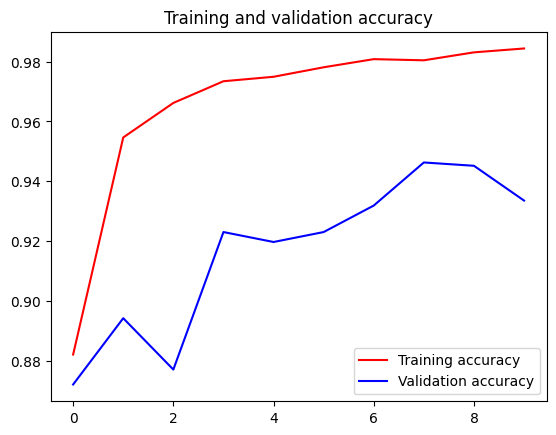

<Figure size 640x480 with 0 Axes>

In [21]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

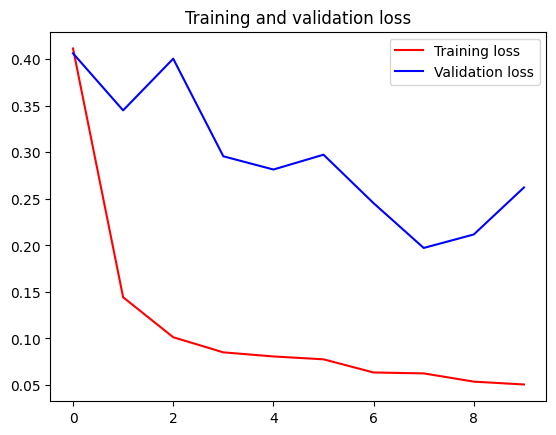

In [22]:
# Plotting training and validation loss
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

# Display the plots
plt.show()

In [23]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 1. Memuat model yang telah dilatih
model.save('final_model.h5')
loaded_model = tf.keras.models.load_model('final_model.h5')

# 2. Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(150, 150))  # Sesuaikan dengan ukuran input model
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    img_array /= 255.0  # Normalisasi
    return img_array

# 3. Mengunggah dan memprediksi gambar
def predict_image(image_path, model):
    img = load_and_preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    class_label = class_names[predicted_class_index]
    #return class_label

    # Membuat output dalam format JSON
    result = {
        'predicted_class_index': int(predicted_class_index),
        'predicted_class_label': class_label,
        'prediction_scores': prediction.tolist()  # Mengubah array numpy ke list agar dapat diserialisasi ke JSON
    }
    return json.dumps(result, indent=4)


# Daftar nama kelas sesuai dengan indeks yang digunakan saat pelatihan
class_names = [
    'Belimbing Wuluh', 'Brotowali', 'Bunga Sepatu', 'Cincau', 'Daun Jarak', 'Daun Kelor', 'Jahe', 'Jambu Biji', 'Jeruk Nipis', 'Kari',
    'Kemangi', 'Kemuning', 'Kunyit', 'Labu Siam', 'Lengkuas', 'Lidah Buaya', 'Meniran', 'Mint', 'Nangka', 'Pandan',
    'Pegagan', 'Pepaya', 'Rumput Teki', 'Sambiloto', 'Seledri', 'Sirih', 'Sirsak', 'Teh Hijau', 'Temulawak'
]

# Path ke gambar uji
image_path = '/content/dataset/Dataset Tanaman Herbal/Dataset Tanaman Herbal/test/Kemangi/Kemangi269.jpg'  # Gantilah dengan path gambar Anda

# Prediksi kelas gambar
predicted_class_label = predict_image(image_path, loaded_model)
print(f'Predicted Class: {predicted_class_label}')

# Prediksi kelas gambar dan mengubah hasil ke JSON
predicted_class_json = predict_image(image_path, loaded_model)
print(predicted_class_json)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step
Predicted Class: {
    "predicted_class_index": 10,
    "predicted_class_label": "Kemangi",
    "prediction_scores": [
        [
            6.034267130416993e-07,
            1.8644503541054291e-07,
            1.1316964787511097e-07,
            0.00035749736707657576,
            2.26768065658689e-07,
            1.0423569563045021e-07,
            1.1003631925632362e-06,
            0.00034190219594165683,
            0.0005587649648077786,
            9.139660051005194e-07,
            0.6861963868141174,
            7.078218455802698e-09,
            2.2632044419879094e-05,
            2.2157733837957494e-05,
            8.060565960477106e-06,
            2.8525505513243843e-07,
            7.197415357040882e-07,
            5.08222512962675e-07,
            0.0015399646945297718,
            1.7674979062576313e-06,
            2.4654274177748903e-09,
            5.127520239511796e-07,
            3.170918461137262e-08,
          

##Convert to JSON


In [24]:
import json

# Mengonversi arsitektur model ke format JSON
model_json = model.to_json()

# Menyimpan JSON ke dalam file
with open("model.json", "w") as json_file:
    json_file.write(model_json)


print("Model telah berhasil dikonversi dan disimpan sebagai JSON!")

Model telah berhasil dikonversi dan disimpan sebagai JSON!


##Konversi TFLite

In [27]:
from tensorflow.keras.models import model_from_json

#Memuat arsitektur model dari file JSON
with open("model.json", "r") as json_file:
    model_json = json_file.read()

model = model_from_json(model_json)

#Memuat bobot model dari file HDF5
model.load_weights("final_model.h5")

#Mengonversi model menjadi format TensorFlow Lite (.tflite)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

#Menyimpan model yang sudah dikonversi ke file .tflite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

#Menyimpan model ke file .bin (opsional)
with open("model.bin", "wb") as f:
    f.write(tflite_model)

print("Konversi selesai! Model .tflite dan .bin telah disimpan.")

Konversi selesai! Model .tflite dan .bin telah disimpan.
